### Load data for one patient

In [1]:
from src.data.data_loader import BrisT1DDataLoader

# Split up data into day and night
loader = BrisT1DDataLoader(use_cached=True)
patient = "p04"

train_df = loader.train_data[loader.train_data["p_num"] == patient]
test_df = loader.validation_data[loader.validation_data["p_num"] == patient]

TIME_STEP_SIZE = (train_df["datetime"].iloc[1] - train_df["datetime"].iloc[0]).components.minutes

if TIME_STEP_SIZE != 5 and TIME_STEP_SIZE != 15:
    error = """
    First time step is not 5 or 15 minutes. Look at the most common time step size.
    """

### Reduce columns and impute missing values on training set

In [2]:
import pandas as pd
from src.tuning.benchmark import impute_missing_values

def reduce_features(df):
	# Make sure index is set to datetime
	p_df = df.iloc[:]
	# p_df.set_index("datetime", inplace=True)
	# p_df = p_df.asfreq('5T', method='pad')

	# Reduce features
	y_feature = ["bg-0:00"]
	x_features = [
		# "hr-0:00", # -> has NaNs
		"steps-0:00",
		"cals-0:00",
		"cob",
		"carb_availability",
		"insulin_availability",
		"iob",
	]
	p_df = p_df[x_features + y_feature]

	# Impute with default methods
	p_df = impute_missing_values(p_df, columns=x_features)
	p_df = impute_missing_values(p_df, columns=y_feature)

	y, X = p_df[y_feature], p_df[x_features]
	return y, X

y_train, X_train = reduce_features(train_df)

/Users/alyss/UW/blood-glucose-control/nocturnal-hypo-gly-prob-forecast/env/lib/python3.12/site-packages/gluonts/json.py:102: UserWarning: Using `json`-module for json-handling. Consider installing one of `orjson`, `ujson` to speed up serialization and deserialization.
  warnings.warn(


In [3]:
y_train.describe()

,bg-0:00
count,18981.00000
mean,7.76561
std,2.24168
min,2.20000
25%,6.30000
50%,7.40000
75%,9.00000
max,18.40000


In [4]:
X_train.describe()

,steps-0:00,cals-0:00,cob,carb_availability,insulin_availability,iob
count,18981.000000,18981.000000,18981.000000,18981.000000,18981.000000,18981.000000
mean,17.608029,5.672639,6.906825,3.227678,0.175720,3.207686
std,63.480308,4.460198,13.169769,5.698760,0.124437,2.325690
min,0.000000,0.910000,0.000000,0.000000,0.000000,0.062500
25%,0.000000,4.550000,0.000000,0.000000,0.086991,1.603157
50%,0.000000,4.550000,0.000000,0.000000,0.134412,2.428425
75%,0.000000,5.540000,9.170969,4.756565,0.229848,4.064129
max,673.000000,42.510000,265.600000,98.948242,0.925510,17.490950


### Select and load model with best params

In [5]:
from src.utils.config_loader import load_yaml_config

# Set relative path to config yaml file with params for model
config_path = "../../src/models/configs/ARCH.yaml"
params = load_yaml_config(config_path)

In [6]:
params

{'p': 15,
 'q': 12,
 'o': 12,
 'lags': 36,
 'power': 1,
 'dist': 'ged',
 'mean': 'AR',
 'vol': 'EGARCH'}

In [7]:
from sktime.forecasting.arch import ARCH  

forecaster = ARCH(**params)

In [8]:
# from sktime.forecasting.ttm import TinyTimeMixerForecaster

# forecaster = TinyTimeMixerForecaster()

### Fit model on training set

In [9]:
import numpy as np

HOURS_TO_PREDICT = 6
NUM_STEPS = HOURS_TO_PREDICT * 60 // TIME_STEP_SIZE

fh=np.arange(1, NUM_STEPS + 1)

forecaster.fit(y=y_train, X=X_train, fh=fh)

/Users/alyss/UW/blood-glucose-control/nocturnal-hypo-gly-prob-forecast/env/lib/python3.12/site-packages/arch/univariate/distribution.py:1194: RuntimeWarning: overflow encountered in power
  lls -= 0.5 * abs(resids / (sqrt(sigma2) * c)) ** nu


ARCH(dist='ged', lags=36, mean='AR', o=12, p=15, power=1, q=12, vol='EGARCH')

### Plot predicted glucose levels

In [10]:
def plot_predicted(ax, forecaster, fh, X_night, test_period):
    predicted_bg = forecaster.predict(fh=fh, X=X_night)
    ax.plot(test_period.index, predicted_bg, label="Predicted glucose levels")


def plot_intervals(ax, forecaster, fh, X_night, test_period):
    pred_int = forecaster.predict_interval(fh=fh, X=X_night, coverage=0.95)[0][0.95]
    ax.plot(
        test_period.index,
        pred_int["upper"],
        label="Predicted upper interval",
        linestyle="--",
    )

    ax.plot(
        test_period.index,
        pred_int["lower"],
        label="Predicted lower interval",
        linestyle="--",
    )


def plot_quantiles(ax, forecaster, fh, X_night, test_period):
    quantiles = [0.95, 0.5, 0.05]
    pred_int = forecaster.predict_quantiles(fh=fh, X=X_night, alpha=quantiles)[
        "bg-0:00"
    ]

    ax.plot(
        test_period.index,
        pred_int[0.05],
        linestyle="--",
        label="0.05 quantile",
    )

    ax.plot(test_period.index, pred_int[0.50], label="0.5 quantile")

    ax.plot(
        test_period.index,
        pred_int[0.95],
        linestyle="--",
        label="0.95 quantile",
    )

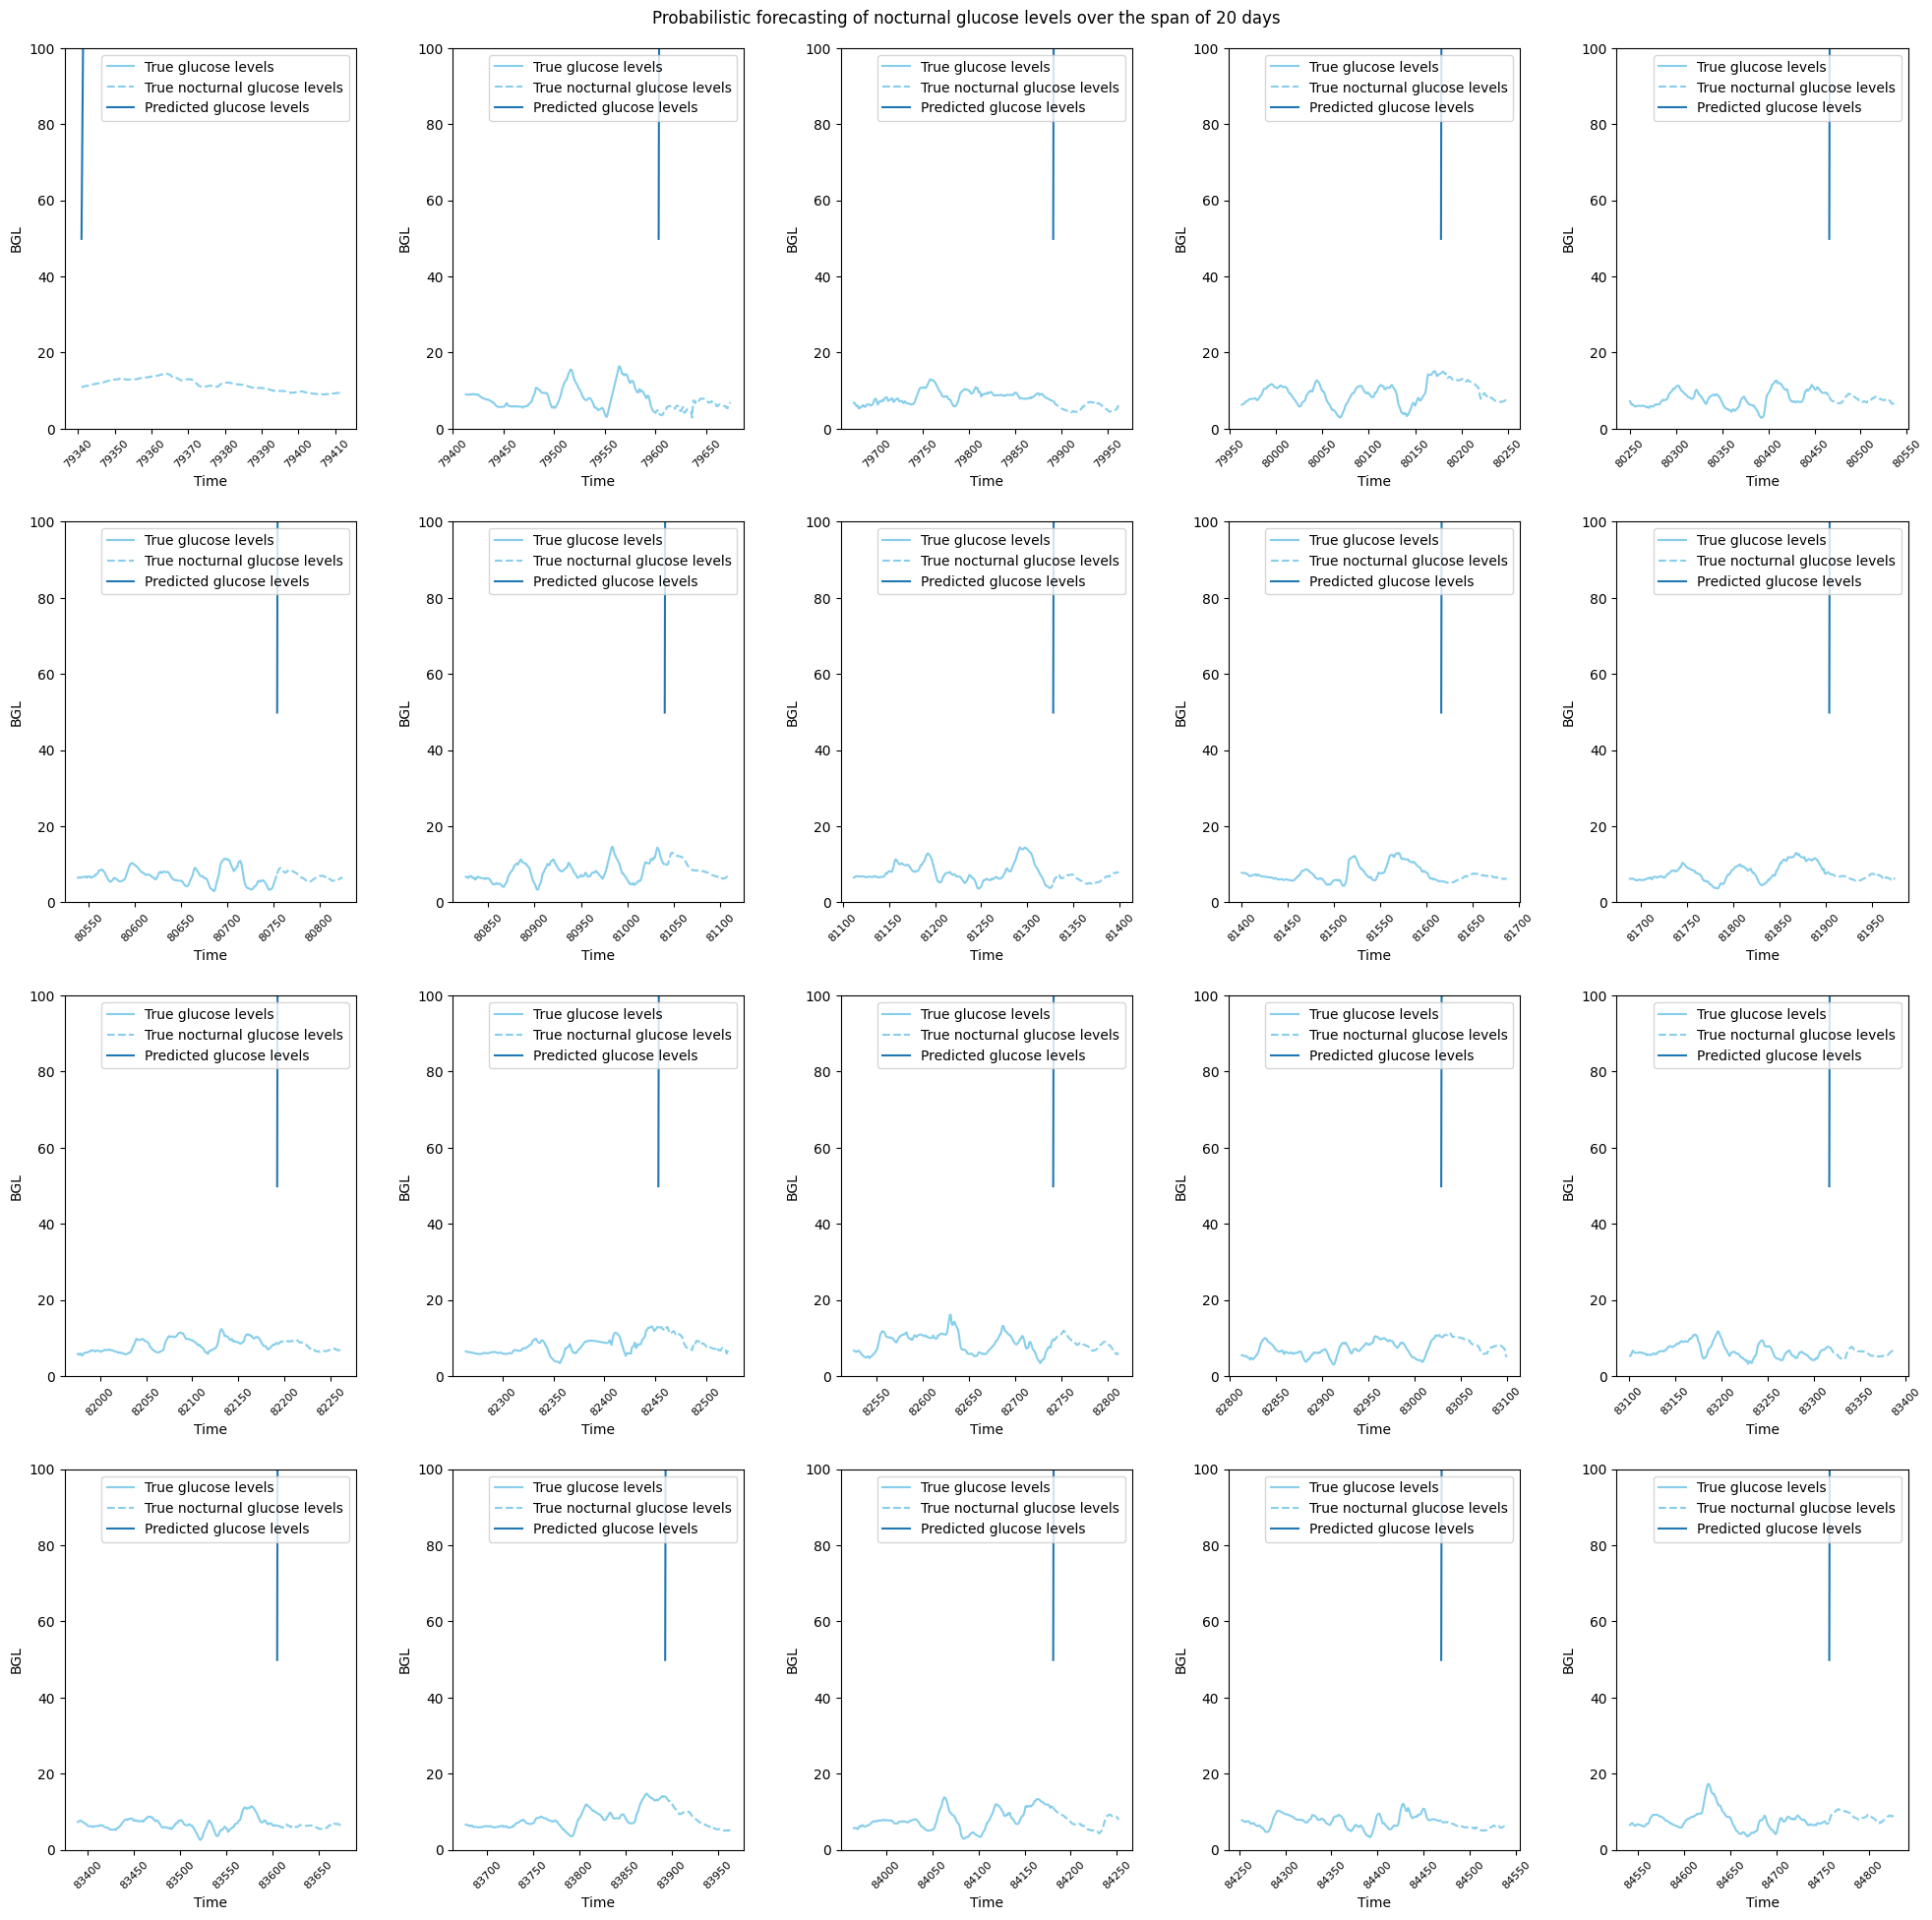

In [11]:
import matplotlib.pyplot as plt

# Create a figure with multiple subplots
fig, axes = plt.subplots(nrows=4, ncols=5, figsize=(20, 20))
fig.suptitle(
    "Probabilistic forecasting of nocturnal glucose levels over the span of 20 days"
)

axes = axes.flatten()  # Flatten the 2D array of axes for easier indexing

# Initialize the subplot counter
subplot_idx = 0

# Loop over each day split
for _, train_period, test_period in loader.get_validation_day_splits(patient):
    y_day, _ = reduce_features(train_period)
    y_night, X_night = reduce_features(test_period)

    ######## Plot true glucose levels ########
    ax = axes[subplot_idx]
    ax.plot(
        train_period.index,
        y_day["bg-0:00"],
        color="skyblue",
        label="True glucose levels",
    )
    ax.plot(
        test_period.index,
        y_night["bg-0:00"],
        color="skyblue",
        linestyle="--",
        label="True nocturnal glucose levels",
    )

    ######## Plot predicted glucose levels ########
    plot_predicted(ax, forecaster, fh, X_night, test_period)
    # plot_intervals(ax, forecaster, fh, X_night, test_period)
    # plot_quantiles(ax, forecaster, fh, X_night, test_period)

    # Add labels, legend, and formatting for each subplot
    ax.set_xlabel("Time", fontsize=10)
    ax.set_ylabel("BGL", fontsize=10)
    ax.set_ylim(0, 100)  # Set the y-axis limits as needed
    ax.legend()
    ax.tick_params(axis="x", rotation=45, labelsize=8)

    # Increment the subplot index for the next day
    subplot_idx += 1

# Adjust layout to avoid overlap
plt.tight_layout(pad=2.0)

# Show the figure with multiple subplots
plt.show()